In [1]:
!pip install pmdarima
import pandas as pd
import glob
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import warnings
import matplotlib.pyplot as plt
from functools import reduce
from tqdm import tqdm
from numpy.linalg import LinAlgError
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

     |████████████████████████████████| 1.5 MB 420 kB/s 


1. Autocorrelation
'babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as a time series.

1.1 Get the autocorrelation and partial autocorrelation for the names Olivia, Newton and John.

1.2 Which name do you expect to be the most popular in 2022? Use an ARIMA model and backtesting to pick 3 interesting candidates. Support your findings with a plot

In [2]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [3]:
df = pd.read_csv('../input/workshop-55/baby_names.csv', index_col = 'year', parse_dates = True).drop(columns = ['Unnamed: 0'])
df = df.reset_index()
df = df.groupby(['year', 'name']).sum().reset_index()

In [4]:
df_olivia = df[df['name']=='Olivia'].sort_values(by = 'year', ascending = True)
df_newton= df[df['name']=='Newton'].sort_values(by = 'year', ascending = True)
df_john = df[df['name']=='John'].sort_values(by = 'year', ascending = True)

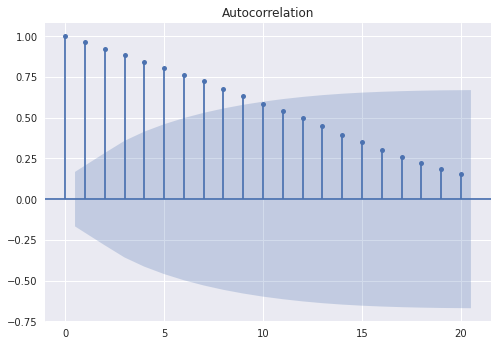

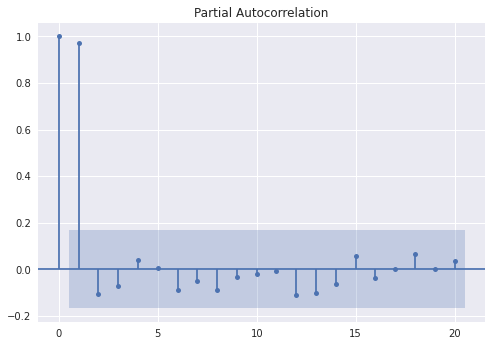

In [5]:
#1.1
#Olivia
plot_acf(df_olivia['num_occurences'], lags=20);
plot_pacf(df_olivia['num_occurences'], lags=20);

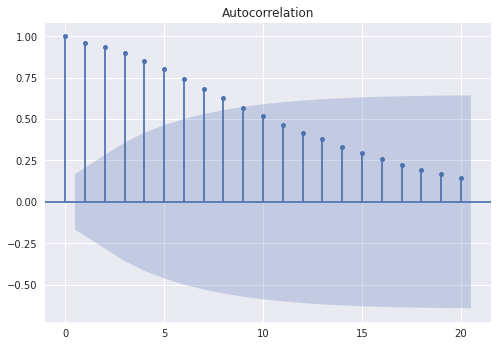

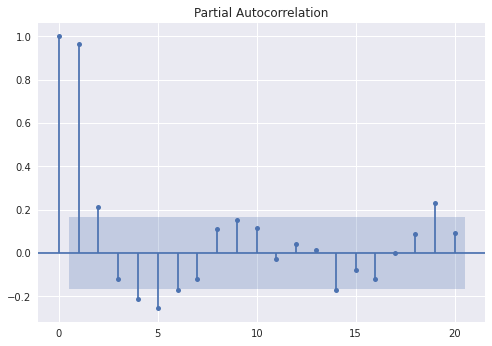

In [6]:
#Newton
plot_acf(df_newton['num_occurences'], lags=20);
plot_pacf(df_newton['num_occurences'], lags=20);


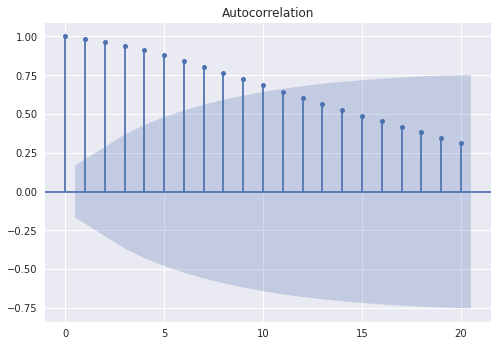

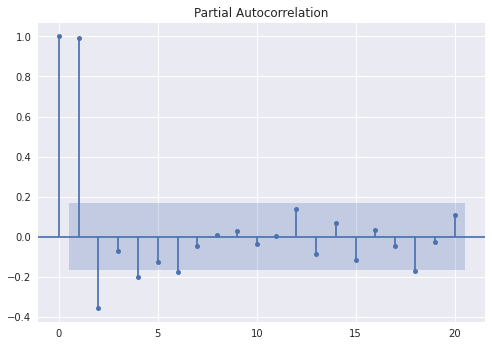

In [7]:
#John
plot_acf(df_john['num_occurences'], lags=20);
plot_pacf(df_john['num_occurences'], lags=20);

In [8]:
names = df.sort_values(by=['year' ,'num_occurences'], ascending = False).name[:500]

In [9]:
#1.2
def predict(df, name):
    tmp = df.copy()
    au_arima = auto_arima(tmp['num_occurences'], start_p =0, start_q = 0, max_p = 6, max_q =3, seasonal = False, Trace = False)
    order = au_arima.order
    try : 
        model = ARIMA(tmp['num_occurences'], order = order)
        res = model.fit()
        predictions = res.predict(start = tmp.index[-1], end = pd.to_datetime('2022-01-01'), typ = 'levels').rename(name)
        predictions = pd.DataFrame(predictions).reset_index()
        return predictions
    except (LinAlgError, ValueError) as e:
        return 'error'
        
        
    

In [10]:
preds = []

for name in tqdm(names): 
    tmp = df[df['name'] == name].set_index('year')
    tmp = tmp.resample(rule='YS').asfreq().interpolate('linear')
    tmp['num_occurences'] = tmp['num_occurences'].astype('float32')
    tmp['name'] = tmp['name'].fillna(method='bfill')
    if len(tmp.loc['1995':'2016'])>20:
        pred = predict(tmp['1995':],name)
        if isinstance(pred, pd.DataFrame) :
            preds.append(pred)




100%|██████████| 500/500 [06:48<00:00,  1.22it/s]


In [11]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['index'],how='outer'), preds).sort_values(by='index')

In [12]:
df_merged = df_merged.rename(columns = {'index':'date'}).set_index('date')


In [13]:
df_merged.index

DatetimeIndex(['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [14]:
df_most_popular_2022 = df_merged.sort_values(by = '2022-01-01', axis = 1, ascending = False)

In [15]:
top10_names_2022 = df_most_popular_2022.columns[:10]

In [16]:
df_top10_names_2022 = df_most_popular_2022[top10_names_2022]

In [17]:
df_top10_names_2022 

,Emma,Charlotte,Olivia,Noah,Oliver,Liam,Ava,Sophia,James,Mia
date,,,,,,,,,,
2016-01-01,20556.225785,13057.659955,20199.571411,20308.824528,11668.349976,18437.460761,17106.161509,17379.196806,15323.439214,15520.333374
2017-01-01,19552.515850,14264.564889,19814.571429,19261.902778,14397.350000,18189.557815,16155.445654,16035.133865,15230.052634,15012.333333
2018-01-01,20219.564705,15808.461387,20368.142857,19720.048937,15868.050000,18389.405131,16361.440330,16427.384219,15694.796696,15644.666667
2019-01-01,20886.613560,17512.565999,20921.714286,20345.308902,17405.100000,18712.778432,16851.274042,16976.655623,16235.232186,16277.000000
2020-01-01,21553.662416,19063.506933,21475.285714,21052.168763,19008.500000,19127.362889,17512.423208,17581.443114,16851.359104,16909.333333
2021-01-01,22220.711271,20826.964064,22028.857143,21798.872987,20678.250000,19609.297347,18239.687047,18205.858776,17543.177449,17541.666667
2022-01-01,22887.760126,22678.264368,22582.428571,22565.032790,22414.350000,20140.962809,18970.371644,18837.214140,18310.687223,18174.000000


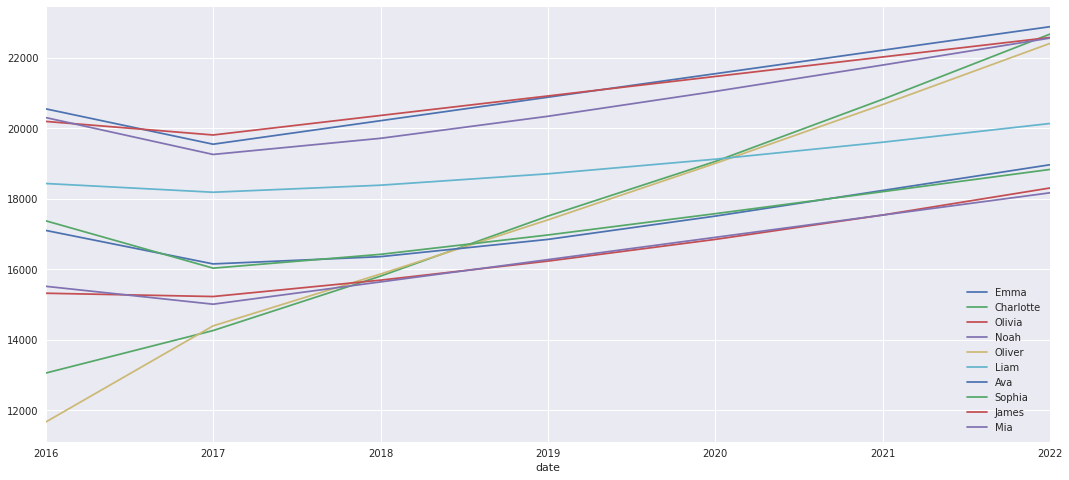

In [18]:
df_top10_names_2022.plot(figsize = (18,8))
plt.show()

# 2. Counterfactual prediction testing

The [FRED](https://fred.stlouisfed.org) database has economic data useful for this question.

A common method to test the effect of a one-off event is to fit an ARIMA model up to the event, and compare the forecast to the actual data of what happened, then measure the gap between the forecast and the event data.

1. Use GDP and unemployment data with the Counterfactual prediction testing methodology to get an estimate of the magnitude of COVID (around March 2020 as a cutoff date) on these two statistics. Use an ARIMA model which fits best to the pre-COVID time series and compare the output of both. Provide a visualization.

2. Is GDP a unit root process or trend stationary? Use the 2008 and 2020 GDP shocks and statistical tests we've seen in class to provide an argument (it's possible event one says one thing and the other event says the opposite).

In [19]:
gdp = pd.read_csv('../input/workshop-55/GDPC1.csv', index_col = 'DATE', parse_dates =True)
gdp.index.freq = 'QS'
unrate = pd.read_csv('../input/workshop-55/UNRATE.csv', index_col = 'DATE', parse_dates =True)
unrate.index.freq = 'MS'

<AxesSubplot:xlabel='DATE'>

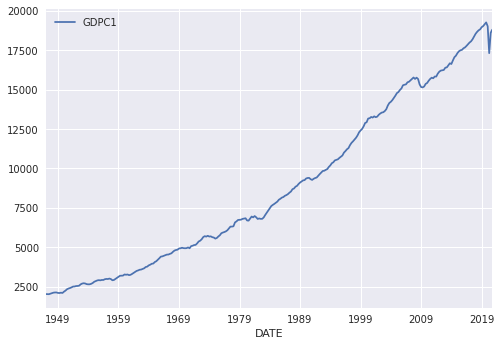

In [20]:
gdp.plot()

In [21]:
gdp_q4_2019 = gdp[:'2019-10-01']
gdp_q4_2019

,GDPC1
DATE,
1947-01-01,2033.061
1947-04-01,2027.639
1947-07-01,2023.452
1947-10-01,2055.103
1948-01-01,2086.017
...,...
2018-10-01,18813.923
2019-01-01,18950.347
2019-04-01,19020.599


In [22]:
au_arima = auto_arima(gdp_q4_2019, start_p =0, start_q = 0, max_p = 6, max_q =6, seasonal = False, Trace = False)
model = ARIMA(gdp_q4_2019, order = au_arima.order)
res = model.fit()
predictions = res.predict(start = '2019-10-01', end = '2021-01-01', typ = 'levels')

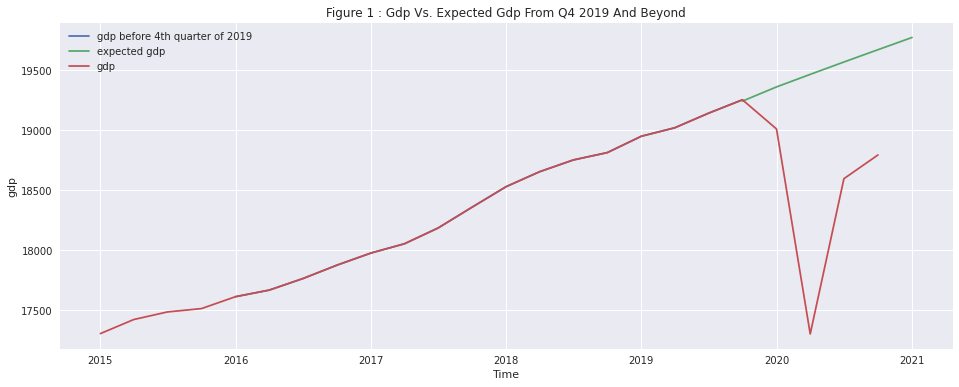

In [23]:
fig, ax = plt.subplots(figsize = (16,6))
ax = plt.plot(gdp_q4_2019['2016':], label = 'gdp before 4th quarter of 2019 ')
ax = plt.plot(predictions, label = 'expected gdp')
ax = plt.plot(gdp['2015':], label = 'gdp')
plt.title('Figure 1 : gdp vs. expected gdp from Q4 2019 and beyond'.title())
plt.ylabel('gdp')
plt.xlabel('Time')
plt.legend()
plt.show()

<AxesSubplot:xlabel='DATE'>

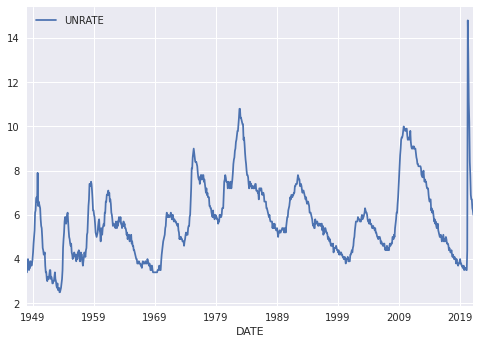

In [24]:
unrate.plot()

<AxesSubplot:xlabel='DATE'>

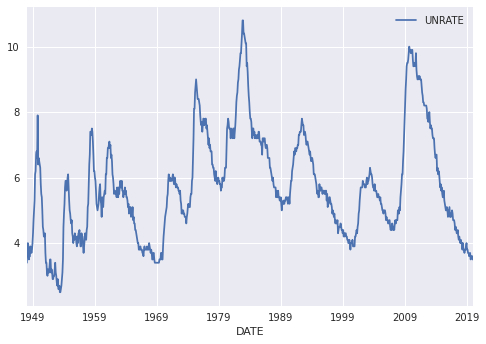

In [25]:
unrate_february_2020 = unrate[:'2020-02']
unrate_february_2020.plot()

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

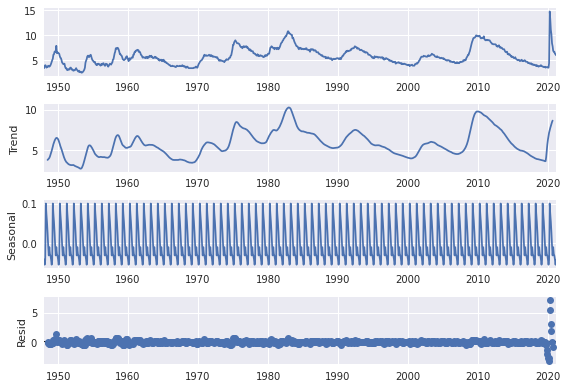

In [27]:
result = seasonal_decompose(unrate, model= 'add')
result.plot();

<AxesSubplot:xlabel='DATE'>

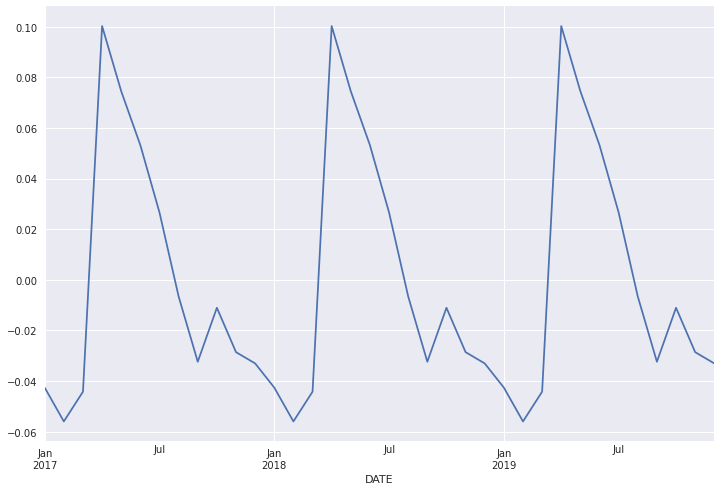

In [28]:
result.seasonal['2017':'2019'].plot(figsize = (12,8))

In [29]:
auto_arima(unrate_february_2020, seasonal = True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  866
Model:             SARIMAX(3, 1, 2)x(2, 0, [1], 12)   Log Likelihood                 233.889
Date:                              Mon, 26 Apr 2021   AIC                           -449.778
Time:                                      00:41:57   BIC                           -406.914
Sample:                                           0   HQIC                          -433.372
                                              - 866                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4874      0.088     16.835      0.000       1.314       1.661
ar.L2         -0.4758      0.077     -6.147      0.000      -0.628      -0.324
ar.L3         -0.1048      0.049     -2.132      0.033      -0.201      -0.008
ma.L1         -1.5148      0.086    -17.671      0.000      -1.683      -1.347
ma.L2          0.6989      0.059     11.905      0.000       0.584       0.814
ar.S.L12       0.5265      0.067      7.859      0.000       0.395       0.658
ar.S.L24      -0.1068      0.041     -2.634      0.008      -0.186      -0.027
ma.S.L12      -0.7391      0.056    -13.082      0.000      -0.850      -0.628
sigma2         0.0339      0.001     28.936      0.000       0.032       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1298.13
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model = SARIMAX(unrate_february_2020, order = (3,1,2), seasonal_order = (2,0,1,12))
res = model.fit()
predictions = res.predict(start = '2020-02-01', end = '2021-02-01', typ= 'levels')

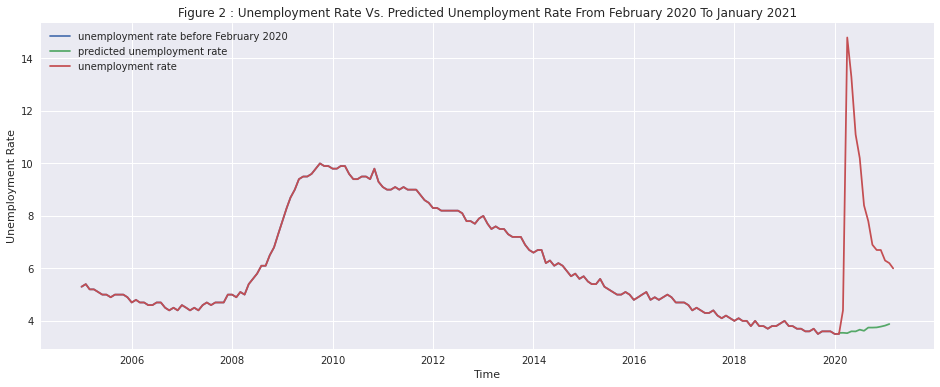

In [31]:
#2.1
fig, ax = plt.subplots(figsize = (16,6))
ax = plt.plot(unrate_february_2020['2005':], label = 'unemployment rate before February 2020')
ax = plt.plot(predictions, label = 'predicted unemployment rate')
ax = plt.plot(unrate['2005':], label = 'unemployment rate')
plt.title('Figure 2 : unemployment rate vs. predicted unemployment rate from February 2020 to January 2021'.title())
plt.ylabel('Unemployment Rate')
plt.xlabel('Time')
plt.legend()
plt.show()

<AxesSubplot:xlabel='DATE'>

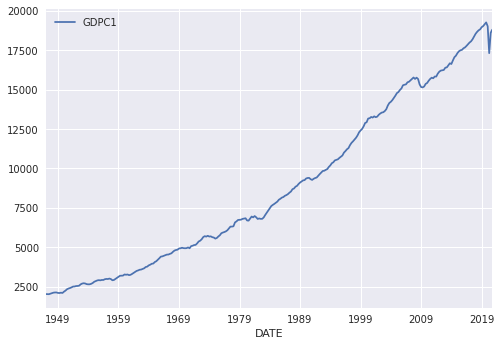

In [32]:
gdp.plot()

In [33]:
gdp_2016_to_2020 = gdp['2016':]

In [34]:
gdp_2004_2012 = gdp['2004':'2012']

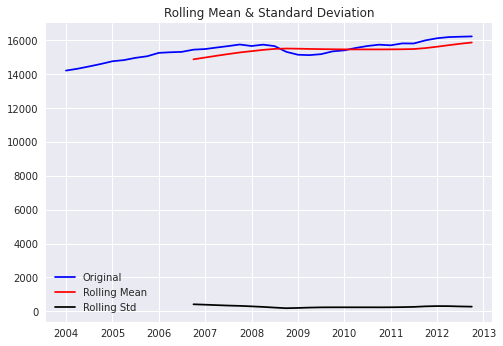

Results of Dickey-Fuller Test:


Test Statistic                 -1.753329
p-value                         0.403866
#Lags Used                      1.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64

In [35]:
test_stationarity(gdp_2004_2012)

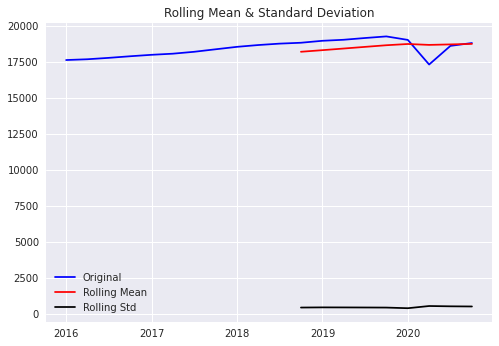

Results of Dickey-Fuller Test:


Test Statistic                 -1.501333
p-value                         0.532852
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

In [36]:
test_stationarity(gdp_2016_to_2020)

In [37]:
#2.2Since p-value is greater than 0.05 for the gdp time series extending from 2004 to 2012 and from 2016 to 2020, 
#we fail to reject the null hypothesis that the time series is non-stationary for the two events.